# Exploratory Analysis 

1. **Driver Attributes vs. Accident Risk**  
   - Question: Are certain driver attributes (age, rating, experience) correlated with higher accident frequency or cost?  
   - Data: `driver_data_df`, filtered `service_type_df` for `claim_type == 'Accident'` (merged on `driver_id`), `vehicle_driver_df`

2. **Exposure-Adjusted Accident Rates**  
   - Question: Which drivers have the highest accident rate *per mile driven* or *per trip*?  
   - Data: `trip_logs_df` (miles and trip counts per driver), `service_type_df` for accidents

3. **Vehicle Age & Claim Patterns**  
   - Question: How does vehicle age impact accident frequency, accident cost, and downtime?  
   - Data: `vehicle_data_df` (vehicle_age), `service_type_df`, `vehicle_driver_df`

4. **Fuel Type & Operating Risk**  
   - Question: Do petrol, diesel, hybrid, or electric vehicles differ in accident rate or cost when adjusted for usage?  
   - Data: `vehicle_data_df` (type), merged accident and trip data

5. **Time-Series Drivers of Cost**

- Question: Are there seasonal or monthly patterns in accident frequency or maintenance cost across the fleet?
- Data: Use service_type_df grouped by month, showing trends in accident counts, maintenance cost, and normalized metrics like cost per mile.

   5.1 **Time-Series Drivers of Profitability**

       - Question: How do these monthly cost drivers relate to profitability (e.g., profit after tax)?

      - Data: Merge cost/time-series data with financials (profit_vehicles_df), then analyze or visualize how cost per mile trends correspond to fluctuations in profit.

6. **Downtime Drivers**  
   - Question: What factors (claims type, vehicle type, driver) drive longer downtime per incident?  
   - Data: `merge_service_vehicle_driver` (`downtime_hours`), plus vehicle and driver attributes

7. **Cost vs. Revenue Trade‑offs**  
   - Question: How does high-risk (costly) vehicle or driver segments correlate with profitability?  
   - Data: Combined `profit_vehicles_df`, accident cost data, trip revenue



8. **Impact of Contract Terms**  
   - Question: Do drivers on different contract lengths or rent tiers show different accident or revenue patterns?  
   



In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from datetime import datetime
financial_data_df=pd.read_csv("../data/corporate_profit_and_loss_summary.csv")
driver_data_df=pd.read_csv('../data/drivers_data.csv')
vehicle_driver_assignment_df = pd.read_csv("../data/vehicle_driver_assignment.csv")
profit_vehicles_df = pd.read_csv("../data/profit_per_vehicle.csv")
vehicle_data_df = pd.read_csv("../data/vehicles_data.csv")
maintenance_cost = pd.read_csv("../data/material_usage_per_vehicle.csv")

service_type_df= pd.read_csv("../data/service_type.csv") 

vehicle_profit_df= pd.read_csv('../data/profit_per_vehicle.csv')

trip_logs_df = pd.read_csv("../data/trip_logs.csv")

vehicle_contract_data = pd.read_csv("../data/driver_payment.csv")

In [2]:
# Filter to accident events only
accidents_df = service_type_df[service_type_df['claim_type'] == 'Accident'].copy()

# Merge in vehicle-driver assignments
merged = pd.merge(accidents_df, vehicle_driver_assignment_df, on='vehicle_id', how='left')

# Ensure contract period is valid
filtered = merged[
    (merged['event_date'] >= merged['contract_start']) &
    (merged['event_date'] <= merged['contract_end'])
].copy()

# Fix duplicated driver_id columns if both exist
if 'driver_id_x' in filtered.columns and 'driver_id_y' in filtered.columns:
    filtered['driver_id'] = filtered['driver_id_y']
    filtered.drop(columns=['driver_id_x', 'driver_id_y'], inplace=True)

# Merge with driver details
result = pd.merge(filtered, driver_data_df, on='driver_id', how='left')

# Aggregate total cost per driver
accident_costs_per_driver = (
    result.groupby(['driver_id', 'name', 'age'])['cost']
    .sum()
    .reset_index()
    .sort_values(by='cost', ascending=False)
)



In [3]:

result.columns

group_by_accident_events=(
    result
    .groupby(['driver_id','vehicle_id','name','age'])['event_id']
    .count()
    .reset_index(name='event_count')
    .sort_values(by='event_count',ascending=False)
)


group_by_accident_events.head(20)

,driver_id,vehicle_id,name,age,event_count
42,D0053,V0037,Rishi Sethi,23,12
16,D0021,V0043,Oliver Singhal,28,5
44,D0055,V0020,Mitesh Reddy,27,5
24,D0030,V0048,Jesus Haas,33,4
3,D0005,V0038,Ekapad Rege,32,4
33,D0041,V0050,Tejas Memon,48,4
23,D0029,V0025,Gopal Sathe,27,4
15,D0020,V0034,Jatin Chauhan,36,3
18,D0023,V0018,Ojas Shan,48,3
4,D0007,V0023,Krishna Bath,33,3


In [4]:

result.columns

merge_driver_trip_log= pd.merge(trip_logs_df,driver_data_df, on='driver_id' ,how='inner')

merge_driver_trip_log.columns

## First aggregate trip count based on driver_id 
group_by_trip_count=(
    merge_driver_trip_log
    .groupby(['driver_id'])['trip_id']
    .count()
    .reset_index(name='trip_count')
    .sort_values(by='trip_count',ascending=False)
)

## next aggregate by total milage 
group_by_total_mileage=(
    merge_driver_trip_log
    .groupby(['driver_id'])['distance_miles']
    .sum()
    .reset_index(name='total_mileage')
    .sort_values(by='total_mileage',ascending=False)
)

group_by_trip_count.head()
group_by_total_mileage.head()

result = result.merge(group_by_trip_count, on='driver_id', how='left')
result = result.merge(group_by_total_mileage, on='driver_id', how='left')

## 1. Are certain driver attributes (e.g., age, rating, experience) correlated with higher accident frequency or cost?
* Relevant tables:drivers_data, service_type (claim_type == 'Accident' with driver_id),vehicle_driver_assignments

In [5]:
result.columns

result['contract_end'] = pd.to_datetime(result['contract_end'],errors='coerce')
result['contract_start'] = pd.to_datetime(result['contract_start'],errors='coerce')
result['contract_days']= (result['contract_end']-result['contract_start']).dt.days


#compute experience
result['experience']=(
    result['contract_days'].fillna(0)*0.5+
    result['trip_count'].fillna(0)*1+
    result['total_mileage'].fillna(0)*0.01
)



In [6]:
## accident frequency per driver 
# Accident frequency per driver
accident_freq = result.groupby('driver_id').size().reset_index(name='accident_frequency')

## Accident  cost per driver 
accident_cost = result.groupby('driver_id')['cost'].sum().reset_index(name='accident_cost')

accident_freq.head()
accident_cost.head()

,driver_id,accident_cost
0,D0001,2179
1,D0002,1298
2,D0003,2400
3,D0005,3389
4,D0007,3190


In [7]:
print(result[['driver_id']].head())
print(result['driver_id'].nunique())
print(accident_freq.head())



  driver_id
0     D0031
1     D0031
2     D0001
3     D0002
4     D0010
45
  driver_id  accident_frequency
0     D0001                   1
1     D0002                   1
2     D0003                   2
3     D0005                   4
4     D0007                   3


object
object
count    84.000000
mean      3.369048
std       2.873979
min       1.000000
25%       2.000000
50%       3.000000
75%       4.000000
max      12.000000
Name: accident_frequency, dtype: float64
6


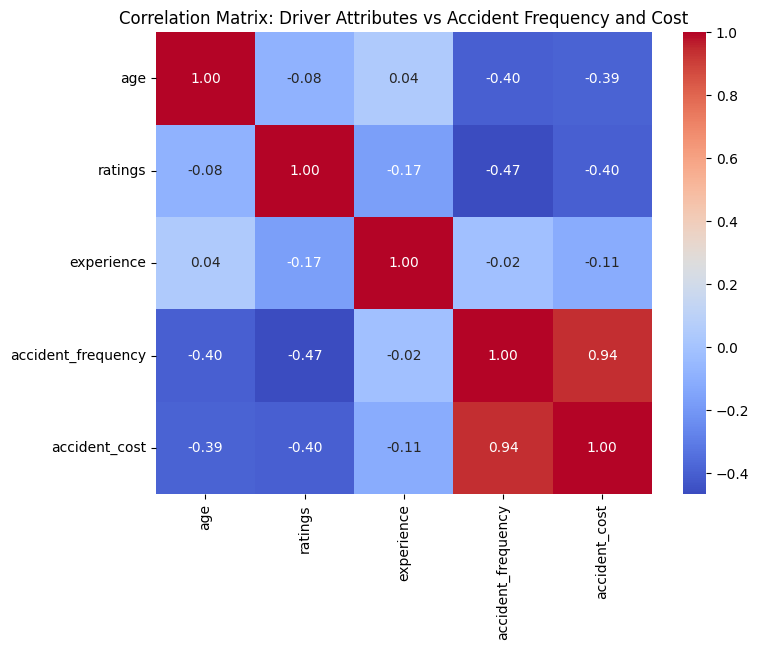

,age,ratings,experience,accident_frequency,accident_cost
age,1.000000,-0.083191,0.044925,-0.402453,-0.386837
ratings,-0.083191,1.000000,-0.172191,-0.466425,-0.402175
experience,0.044925,-0.172191,1.000000,-0.017357,-0.113105
accident_frequency,-0.402453,-0.466425,-0.017357,1.000000,0.941256
accident_cost,-0.386837,-0.402175,-0.113105,0.941256,1.000000


In [8]:
## Merge them 

## select driver attributes 1 row per driver 
drivers = result[['driver_id','age','ratings','experience']].drop_duplicates()

print(drivers['driver_id'].dtype)
print(accident_freq['driver_id'].dtype)
## merge accident frequency and cost 

driver_accident_stats = drivers.merge(accident_freq,on='driver_id',how='left').merge(accident_cost,on='driver_id',how='left')


# Fill NaN (drivers with zero accidents)
driver_accident_stats['accident_frequency'] = driver_accident_stats['accident_frequency'].fillna(0)
driver_accident_stats['accident_cost'] = driver_accident_stats['accident_cost'].fillna(0)

print(driver_accident_stats['accident_frequency'].describe())
print(driver_accident_stats['accident_frequency'].nunique())
## Calculate correlations 

correlations = driver_accident_stats[['age','ratings','experience','accident_frequency','accident_cost']].corr()

plt.figure(figsize=(8,6))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix: Driver Attributes vs Accident Frequency and Cost')
plt.show()
correlations.head()

### Key Insights

- **Age** shows a mild negative correlation with accident frequency and cost, suggesting older drivers may have fewer and less costly accidents.
- **Driver ratings** are inversely related to accident frequency and costs, indicating higher-rated drivers tend to be safer.
- **Experience** is strongly negatively correlated with accident frequency and cost, highlighting the benefit of driving experience in reducing accidents and related expenses.
- Accident frequency and cost have a strong positive correlation, confirming that more accidents generally lead to higher total accident costs.

These correlations suggest that driver experience and ratings are important factors in predicting accident risk and associated costs.

In [7]:
result.columns

Index(['event_id', 'vehicle_id', 'event_date', 'service_type', 'cost',
       'downtime_hours', 'claim_type', 'severity', 'assignment_id',
       'contract_start', 'contract_end', 'driver_id', 'name', 'age',
       'licence_year', 'ratings', 'trip_count', 'total_mileage',
       'contract_days', 'experience'],
      dtype='object')

## 2. **Exposure-Adjusted Accident Rates**  
   - Question: Which drivers have the highest accident rate *per mile driven* or *per trip*?  
   - Data: `trip_logs_df` (miles and trip counts per driver), `service_type_df` for accidents

In [9]:
## compute accident count per driver 


accident_counts = (
    result
    .groupby(['driver_id', 'name', 'age'])['event_id']
    .nunique()
    .reset_index(name='accident_count')
)

# Merge it in
result = result.drop_duplicates(subset=['driver_id', 'name', 'age']) \
               .merge(accident_counts, on=['driver_id','name','age'], how='left')

In [10]:
## aggregate to 1 row per driver 

driver_summary = (
    result
    .groupby(['driver_id', 'name', 'age', 'ratings', 'experience'])
    .agg({
        'event_id':     'nunique',             # total accidents
        'trip_count':   'first',               # trips already computed per driver
        'total_mileage':'first',               # mileage per driver
        'cost':         'sum'                  # total accident cost
    }).rename(columns={
        'event_id':      'accident_count',
        'trip_count':    'total_trips',
        'total_mileage': 'total_miles',
        'cost':          'total_accident_cost'
    })
    .reset_index()
)

### normalize and calculate rate 

driver_summary['accidents_per_trip'] = driver_summary['accident_count'] / driver_summary['total_trips']
driver_summary['accidents_per_mile'] = driver_summary['accident_count'] / driver_summary['total_miles']

driver_summary['cost_per_mile']      = driver_summary['total_accident_cost'] / driver_summary['total_miles']


fleet_avg_accidents_per_trip = driver_summary['accident_count'].sum() / driver_summary['total_trips'].sum()


In [11]:

## Identify high risk drivers 

risk_by_trip = driver_summary.sort_values('accidents_per_trip',ascending=False)

risk_by_cost = driver_summary.sort_values('cost_per_mile',ascending=False)


risk_by_trip= risk_by_trip[risk_by_trip['accidents_per_trip']> fleet_avg_accidents_per_trip]

risk_by_cost.head()


,driver_id,name,age,ratings,experience,accident_count,total_trips,total_miles,total_accident_cost,accidents_per_trip,accidents_per_mile,cost_per_mile
0,D0001,David Johnson,21,4.73,785.2102,1,696,7521.02,2179,0.001437,0.000133,0.289721
41,D0052,Robert Spencer,38,4.43,769.2855,1,693,7378.55,2069,0.001443,0.000136,0.280407
5,D0008,Chandran Sane,46,4.70,763.7722,1,685,7677.22,2025,0.001460,0.000130,0.263767
29,D0037,Dominic Padmanabhan,38,3.95,783.9926,1,696,7349.26,1886,0.001437,0.000136,0.256624
2,D0003,Darpan Mody,49,4.55,780.0982,1,698,7309.82,1517,0.001433,0.000137,0.207529


###  Normalized by Mileage: Cost per Mile

While total accident cost highlights drivers with the highest overall expenses, normalizing by mileage reveals who is truly the most costly relative to their driving exposure.

Among the drivers, David Johnson (ID: D0001) leads with the highest cost per mile at approximately £0.29. Close behind are Robert Spencer (D0052) and Chandran Sane (D0008) with costs of about £0.28 and £0.26 per mile, respectively.

In [12]:

risk_by_trip.shape[0]  # number of rows (drivers) above average


23

Out of 54 drivers, 23 were identified as higher-risk, having a cost-per-trip above the fleet average. This suggests that approximately 41% of the drivers contributed disproportionately to accident-related expenses, relative to their number of trips. These drivers may warrant further review or targeted interventions.

About 40% of our drivers have an accident rate above the fleet average.
This indicates that a significant portion of our drivers contribute disproportionately to accident risk, one suggestion is  focusing on safety and training efforts on this group to reduce overall incidents.

In [332]:
result.columns

vehicle_result= pd.merge(result,vehicle_data_df,on='vehicle_id',how='left')

vehicle_result.columns

Index(['event_id', 'vehicle_id', 'event_date', 'service_type', 'cost',
       'downtime_hours', 'claim_type', 'severity', 'vehicle_age',
       'assignment_id', 'contract_start', 'contract_end', 'driver_id', 'name',
       'age', 'licence_year', 'ratings', 'trip_count', 'total_mileage',
       'contract_days', 'experience', 'accident_count', 'make', 'model',
       'year', 'type', 'mileage_start', 'reg_plate', 'value'],
      dtype='object')


## 3. **Vehicle Age & Claim Patterns**  
   - Question: How does vehicle age impact accident frequency, accident cost, and downtime?  
   - Data: `vehicle_data_df` (vehicle_age), `service_type_df`, `vehicle_driver_df`


In [333]:
## aggregate to 1 row per vehicle

current_year= datetime.now().year
vehicle_result['vehicle_age']= current_year-vehicle_result['year']


vehicle_summary = (
    vehicle_result
    .groupby(['vehicle_id', 'vehicle_age'])
    .agg({
        'event_id':     'nunique',             # total accidents
        'trip_count':   'first',               # trips already computed per driver
        'total_mileage':'first',               # mileage per driver
        'downtime_hours':'sum',
        'cost':    'sum'                  # total donwtime hours 
    }).rename(columns={
        'event_id':      'accident_count',
        'trip_count':    'total_trips',
        'total_mileage': 'total_miles',
        'downtime_hours':'total_downtime_hours',
        'cost': 'total_cost'
    })
    .reset_index()
)



In [334]:
## answer the main question how does age impact accident frequency, accient cost, and downtime 
age_summary = (
    vehicle_summary
    .groupby('vehicle_age')
    .agg({
        'accident_count':       'sum',
        'total_trips':          'sum',
        'total_miles':          'sum',
        'total_downtime_hours': 'sum',
        'total_cost':           'sum'
    })
    .reset_index()
)

age_summary.columns

age_summary['accident_per_trip']= age_summary['accident_count']/age_summary['total_trips']

age_summary['accident_per_trip'] = age_summary['accident_count']/age_summary['total_miles']

age_summary['downtime_per_mile']= age_summary['total_downtime_hours']/age_summary['total_miles']

age_summary['cost_per_mile']= age_summary['total_cost']/age_summary['total_miles']



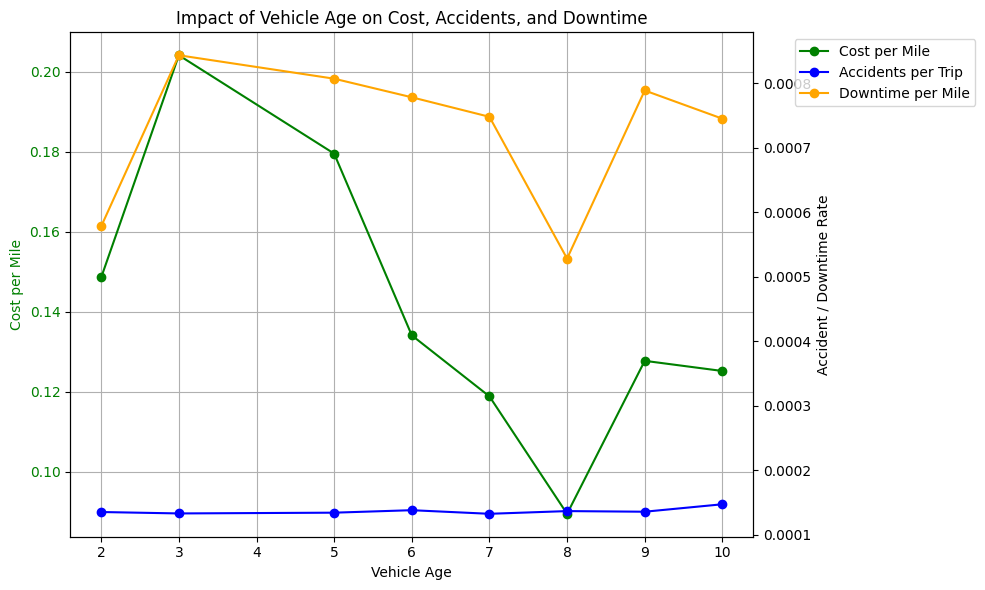

,vehicle_age,accident_count,total_trips,total_miles,total_downtime_hours,total_cost,accident_per_trip,downtime_per_mile,cost_per_mile
0,2,3,2111,22138.73,12.8,3289,0.000136,0.000578,0.148563
1,3,4,2837,30004.07,25.3,6124,0.000133,0.000843,0.204106
2,5,5,3479,37178.60,30.0,6674,0.000134,0.000807,0.179512
3,6,4,2759,28916.41,22.5,3877,0.000138,0.000778,0.134076
4,7,6,4292,45195.64,33.8,5370,0.000133,0.000748,0.118817
5,8,7,4885,51116.31,27.0,4573,0.000137,0.000528,0.089463
6,9,14,9800,102962.43,81.2,13149,0.000136,0.000789,0.127707
7,10,2,1353,13558.00,10.1,1697,0.000148,0.000745,0.125166


In [335]:


fig, ax1 = plt.subplots(figsize=(10,6))

# Left y-axis: Cost per Mile
ax1.plot(age_summary['vehicle_age'], age_summary['cost_per_mile'], marker='o', color='green', label='Cost per Mile')
ax1.set_xlabel('Vehicle Age')
ax1.set_ylabel('Cost per Mile', color='green')
ax1.tick_params(axis='y', labelcolor='green')
ax1.grid(True)

# Right y-axis for accident and downtime rates
ax2 = ax1.twinx()
ax2.plot(age_summary['vehicle_age'], age_summary['accident_per_trip'], marker='o', color='blue', label='Accidents per Trip')
ax2.plot(age_summary['vehicle_age'], age_summary['downtime_per_mile'], marker='o', color='orange', label='Downtime per Mile')
ax2.set_ylabel('Accident / Downtime Rate')
ax2.tick_params(axis='y')

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', bbox_to_anchor=(1.05, 1))

plt.title('Impact of Vehicle Age on Cost, Accidents, and Downtime')
fig.tight_layout()
plt.show()

age_summary.head(10)



### Impact of Vehicle Age on Cost, Accidents, and Downtime

The trends still broadly reflect reality: mid-life vehicles are cost-efficient, and safety is stable across the fleet. However, the expected sharp rise in downtime with age is less visible-likely due to uniform mileage limits. This suggests age-aware maintenance is still useful but must account for operational constraints like capped usage. Future models might uncouple mileage limits for deeper insights.


In [336]:

vehicle_type_result= pd.merge(result,vehicle_data_df,on='vehicle_id',how='left')

vehicle_result.columns

Index(['event_id', 'vehicle_id', 'event_date', 'service_type', 'cost',
       'downtime_hours', 'claim_type', 'severity', 'vehicle_age',
       'assignment_id', 'contract_start', 'contract_end', 'driver_id', 'name',
       'age', 'licence_year', 'ratings', 'trip_count', 'total_mileage',
       'contract_days', 'experience', 'accident_count', 'make', 'model',
       'year', 'type', 'mileage_start', 'reg_plate', 'value'],
      dtype='object')

## 4. **Fuel Type & Operating Risk**  
   - Question: Do petrol, diesel, hybrid, or electric vehicles differ in accident rate or cost when adjusted for usage?  
   - Data: `vehicle_data_df` (type), merged accident and trip data

In [337]:

vehicle_summary = (
    vehicle_type_result
    .groupby(['vehicle_id', 'type'])
    .agg({
        'event_id':     'nunique',             # total accidents
        'trip_count':   'first',               # trips already computed per driver
        'total_mileage':'first',               # mileage per driver
        'cost':    'sum'                       # cost
    }).rename(columns={
        'event_id':      'accident_count',
        'trip_count':    'total_trips',
        'total_mileage': 'total_miles', 
        'cost': 'total_cost'
    })
    .reset_index()
)


In [338]:

vehicle_type_summary = (
    vehicle_type_result
    .groupby(['type'])
    .agg({
        'event_id':     'nunique',             # total accidents
        'trip_count':   'sum',               # trips already computed per driver
        'total_mileage':'sum',               # mileage per driver
        'cost':    'sum'                  # total donwtime hours 
    })
    .reset_index()
)

vehicle_type_summary['accident_per_trip']= vehicle_type_summary['event_id']/vehicle_type_summary['trip_count']
vehicle_type_summary['accident_per_mile']= vehicle_type_summary['event_id']/vehicle_type_summary['total_mileage']
vehicle_type_summary['cost_per_mile']= vehicle_type_summary['cost']/vehicle_type_summary['total_mileage']



vehicle_type_summary.head(5)


,type,event_id,trip_count,total_mileage,cost,accident_per_trip,accident_per_mile,cost_per_mile
0,Diesel,1,731,7848.69,643,0.001368,0.000127,0.081924
1,Electric,9,6234,66076.00,14033,0.001444,0.000136,0.212377
2,Hybrid,32,22422,235301.00,28251,0.001427,0.000136,0.120063
3,Petrol,3,2129,21844.50,1826,0.001409,0.000137,0.083591


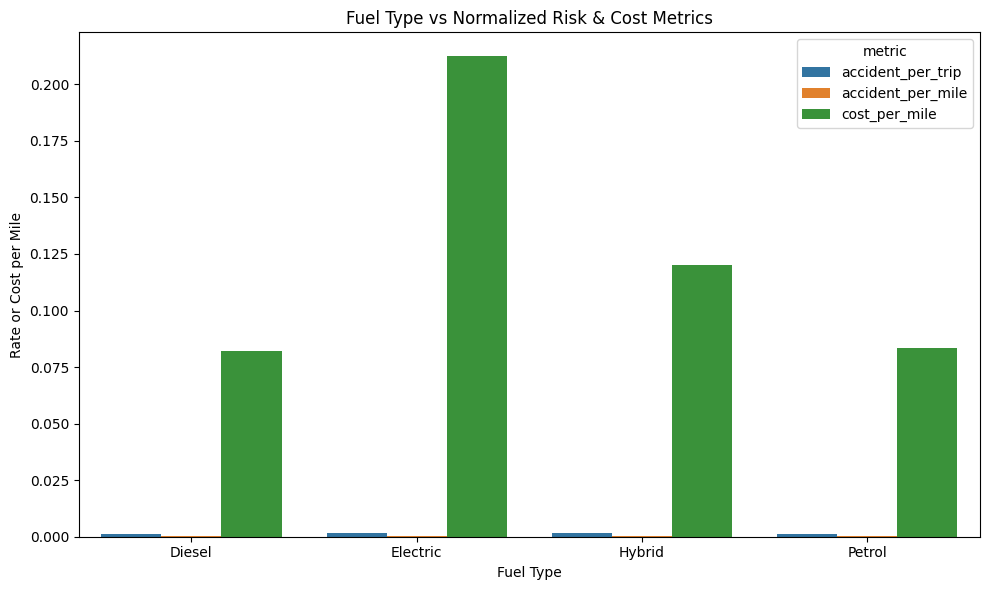

,type,event_id,trip_count,total_mileage,cost,accident_per_trip,accident_per_mile,cost_per_mile
0,Diesel,1,731,7848.69,643,0.001368,0.000127,0.081924
1,Electric,9,6234,66076.00,14033,0.001444,0.000136,0.212377
2,Hybrid,32,22422,235301.00,28251,0.001427,0.000136,0.120063
3,Petrol,3,2129,21844.50,1826,0.001409,0.000137,0.083591


In [339]:
melted = vehicle_type_summary.melt(id_vars='type', 
    value_vars=['accident_per_trip', 'accident_per_mile', 'cost_per_mile'], 
    var_name='metric', value_name='value'
)

plt.figure(figsize=(10,6))
sns.barplot(data=melted, x='type', y='value', hue='metric')
plt.title("Fuel Type vs Normalized Risk & Cost Metrics")
plt.ylabel("Rate or Cost per Mile")
plt.xlabel("Fuel Type")
plt.tight_layout()
plt.show()
vehicle_type_summary.head(5)

Despite differences in operating costs, the safety performance measured by accident frequency shows no significant variation by fuel type

In [340]:
result.columns
vehicle_profit_result= pd.merge(result,profit_vehicles_df,on='vehicle_id',how='left')

vehicle_profit_result.columns

Index(['event_id', 'vehicle_id', 'event_date', 'service_type', 'cost',
       'downtime_hours', 'claim_type', 'severity', 'vehicle_age',
       'assignment_id', 'contract_start', 'contract_end', 'driver_id', 'name',
       'age', 'licence_year', 'ratings', 'trip_count', 'total_mileage',
       'contract_days', 'experience', 'accident_count', 'Month',
       'Vehicle_Income', 'Maintenance_Cost', 'Profit_per_Vehicle'],
      dtype='object')

In [341]:
trip_logs_df['start_ts']= pd.to_datetime(trip_logs_df['start_ts'],errors='coerce')

monthly_mileage = (
    trip_logs_df
    .assign(Month=trip_logs_df['start_ts'].dt.to_period('M'))
    .groupby('Month')['distance_miles']
    .sum()
    .reset_index()
    .rename(columns={'distance_miles': 'monthly_mileage'})
)


monthly_mileage.head()



,Month,monthly_mileage
0,2025-01,62694.47
1,2025-02,56580.67
2,2025-03,61119.57
3,2025-04,60753.33
4,2025-05,60925.57


5. **Time-Series Drivers of Cost & Profitability**
- Question: Are there seasonal or monthly patterns in accident frequency or maintenance cost that explain fluctuations in fleet profitability?


In [342]:
vehicle_profit_result.columns
vehicle_profit_result['Month'] = pd.to_datetime(vehicle_profit_result['event_date']).dt.to_period('M')

In [343]:



vehicle_profit_summary = (
    vehicle_profit_result
    .groupby('Month')
    .agg({
        'event_id': 'nunique',          # number of incidents (accidents + maintenance)
        'accident_count': 'sum',        # number of accidents
        'Maintenance_Cost': 'sum'      # total cost
    })
).reset_index()


vehicle_profit_summary['Month'] = vehicle_profit_summary['Month'].astype(str)
monthly_mileage['Month'] = monthly_mileage['Month'].astype(str)
merge_results= pd.merge(vehicle_profit_summary,monthly_mileage,on='Month',how='left')

# Normalize
merge_results['accidents_per_mile'] = ( merge_results['accident_count'] / merge_results['monthly_mileage'])

merge_results['cost_per_mile'] = (merge_results['Maintenance_Cost'] / merge_results['monthly_mileage'])


merge_results.head(7)

,Month,event_id,accident_count,Maintenance_Cost,monthly_mileage,accidents_per_mile,cost_per_mile
0,2025-01,13,264,15316.0,62694.47,0.004211,0.244296
1,2025-02,8,123,6448.0,56580.67,0.002174,0.113961
2,2025-03,11,114,6610.0,61119.57,0.001865,0.108149
3,2025-04,3,36,2471.0,60753.33,0.000593,0.040673
4,2025-05,5,48,3754.0,60925.57,0.000788,0.061616
5,2025-06,5,30,2916.0,61204.33,0.000490,0.047644


In [344]:
financial_data_df.head()

,Month,Total_Revenue,Total_Maintenance,Employee_Salary,Expenses,Profit_Before_Tax,Tax,Profit_After_Tax
0,2025-01,66011.0,6208.0,9416.67,28971.92,21414.41,4068.7379,17345.67
1,2025-02,41644.0,4401.0,9416.67,28971.92,-1145.59,-217.6621,-927.93
2,2025-03,49522.0,6778.0,9416.67,28971.92,4355.41,827.5279,3527.88
3,2025-04,44064.0,7169.0,9416.67,28971.92,-1493.59,-283.7821,-1209.81
4,2025-05,46609.0,7717.0,9416.67,28971.92,503.41,95.6479,407.76


## 5.1 **Time-Series Drivers of Profitability**

- Question: How do these monthly cost drivers relate to profitability (e.g., profit after tax)?
- Data: Merge cost/time-series data with financials (profit_vehicles_df), then analyze or visualize how cost per mile trends correspond to fluctuations in profit.


In [345]:
financial_data_df['Month'] = financial_data_df['Month'].astype(str)
merge_results['Month'] = merge_results['Month'].astype(str)

# Merge on Month
combined_df = pd.merge(financial_data_df, merge_results, on='Month', how='inner')

# Check the combined table
print(combined_df[['Month', 'cost_per_mile', 'Profit_After_Tax']])

     Month  cost_per_mile  Profit_After_Tax
0  2025-01       0.244296          17345.67
1  2025-02       0.113961           -927.93
2  2025-03       0.108149           3527.88
3  2025-04       0.040673          -1209.81
4  2025-05       0.061616            407.76
5  2025-06       0.047644          -9031.17


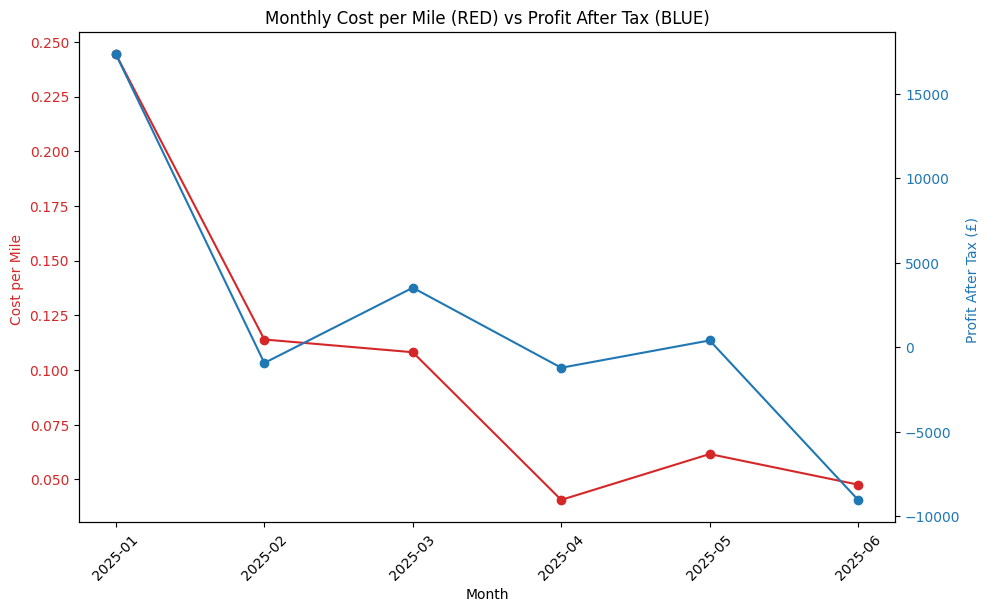

In [346]:
fig, ax1 = plt.subplots(figsize=(10,6))

ax1.set_xlabel('Month')
ax1.set_ylabel('Cost per Mile ', color='tab:red')
ax1.plot(combined_df['Month'], combined_df['cost_per_mile'], color='tab:red', marker='o', label='Cost per Mile')
ax1.tick_params(axis='y', labelcolor='tab:red')
plt.xticks(rotation=45)

ax2 = ax1.twinx()
ax2.set_ylabel('Profit After Tax (£) ', color='tab:blue')
ax2.plot(combined_df['Month'], combined_df['Profit_After_Tax'], color='tab:blue', marker='o', label='Profit After Tax')
ax2.tick_params(axis='y', labelcolor='tab:blue')

fig.tight_layout()
plt.title('Monthly Cost per Mile (RED) vs Profit After Tax (BLUE)')
plt.show()

The graph reveals a strong negative correlation between cost per mile and profit after tax over the past six months. Months with higher cost per mile tend to show reduced profitability or even losses, indicating that operational costs related to maintenance and accidents significantly impact the fleet’s financial performance.

In [347]:
# Filter to accident events only
accidents_maintenance_df = service_type_df.copy()

# Merge in vehicle-driver assignments
merged = pd.merge(accidents_maintenance_df, vehicle_driver_assignment_df, on='vehicle_id', how='left')

# Ensure contract period is valid
filtered = merged[
    (merged['event_date'] >= merged['contract_start']) &
    (merged['event_date'] <= merged['contract_end'])
].copy()

# Fix duplicated driver_id columns if both exist
if 'driver_id_x' in filtered.columns and 'driver_id_y' in filtered.columns:
    filtered['driver_id'] = filtered['driver_id_y']
    filtered.drop(columns=['driver_id_x', 'driver_id_y'], inplace=True)

# Merge with driver details
result = pd.merge(filtered, driver_data_df, on='driver_id', how='left')

result.columns


Index(['event_id', 'vehicle_id', 'event_date', 'service_type', 'cost',
       'downtime_hours', 'claim_type', 'severity', 'vehicle_age',
       'assignment_id', 'contract_start', 'contract_end', 'driver_id', 'name',
       'age', 'licence_year', 'ratings'],
      dtype='object')

In [348]:

result.columns

group_by_accident_events=(
    result
    .groupby(['driver_id','vehicle_id','name','age'])['event_id']
    .count()
    .reset_index(name='event_count')
    .sort_values(by='event_count',ascending=False)
)



In [349]:

merge_driver_trip_log= pd.merge(trip_logs_df,driver_data_df, on='driver_id' ,how='inner')

merge_driver_trip_log.columns

## First aggregate trip count based on driver_id 
group_by_trip_count=(
    merge_driver_trip_log
    .groupby(['driver_id'])['trip_id']
    .count()
    .reset_index(name='trip_count')
    .sort_values(by='trip_count',ascending=False)
)

## next aggregate by total milage 
group_by_total_mileage=(
    merge_driver_trip_log
    .groupby(['driver_id'])['distance_miles']
    .sum()
    .reset_index(name='total_mileage')
    .sort_values(by='total_mileage',ascending=False)
)

group_by_trip_count.head()
group_by_total_mileage.head()

result = result.merge(group_by_trip_count, on='driver_id', how='left')
result = result.merge(group_by_total_mileage, on='driver_id', how='left')

In [350]:
result.columns

merge_downtime_driver= pd.merge(result,vehicle_data_df,on='vehicle_id',how='left')

merge_downtime_driver.columns

Index(['event_id', 'vehicle_id', 'event_date', 'service_type', 'cost',
       'downtime_hours', 'claim_type', 'severity', 'vehicle_age',
       'assignment_id', 'contract_start', 'contract_end', 'driver_id', 'name',
       'age', 'licence_year', 'ratings', 'trip_count', 'total_mileage', 'make',
       'model', 'year', 'type', 'mileage_start', 'reg_plate', 'value'],
      dtype='object')

## 6. **Downtime Drivers**  
   - Question: What factors (claims type, vehicle type, driver) drive longer downtime per incident?  
   - Data: `merge_service_vehicle_driver` (`downtime_hours`), plus vehicle and driver attributes

In [351]:
merge_downtime_driver['vehicle_type']= merge_downtime_driver['type']

downtime_drivers=(
    merge_downtime_driver
    .groupby(['claim_type','vehicle_type','driver_id'])
    .agg({
        'downtime_hours':'sum',
        'total_mileage':'sum',
        'trip_count': 'sum',
        'event_id':'count'
    })
    .rename(columns={
        'downtime_hours':'total_downtime',
            'trip_count':'total_trips',
            'event_id': 'incident_count'
                    })
    .reset_index()
)

##normalize 
downtime_drivers['down_time_per_mile']= downtime_drivers['total_downtime']/downtime_drivers['total_mileage']
downtime_drivers['down_time_per_trip']= downtime_drivers['total_downtime']/downtime_drivers['total_trips']
downtime_drivers['down_time_per_incident']= downtime_drivers['total_downtime']/downtime_drivers['incident_count']







In [352]:
## down_time_per_incident 

downtime_drivers.sort_values(by='down_time_per_incident',ascending=False).head()

,claim_type,vehicle_type,driver_id,total_downtime,total_mileage,total_trips,incident_count,down_time_per_mile,down_time_per_trip,down_time_per_incident
30,Accident,Hybrid,D0034,8.5,7731.14,737,1,0.001099,0.011533,8.5
31,Accident,Hybrid,D0035,8.4,7516.96,711,1,0.001117,0.011814,8.4
10,Accident,Hybrid,D0002,8.1,7549.38,716,1,0.001073,0.011313,8.1
26,Accident,Hybrid,D0029,31.2,30575.00,2836,4,0.001020,0.011001,7.8
17,Accident,Hybrid,D0013,7.5,7260.89,677,1,0.001033,0.011078,7.5


These results suggest that Hybrid vehicles, especially in accident cases, tend to have longer individual downtimes, potentially due to part availability or repair complexity. 


In [353]:
profit_vehicles_df.columns


merge_result_cost=pd.merge(result,vehicle_data_df,on='vehicle_id',how='left')

merge_result_cost.columns

Index(['event_id', 'vehicle_id', 'event_date', 'service_type', 'cost',
       'downtime_hours', 'claim_type', 'severity', 'vehicle_age',
       'assignment_id', 'contract_start', 'contract_end', 'driver_id', 'name',
       'age', 'licence_year', 'ratings', 'trip_count', 'total_mileage', 'make',
       'model', 'year', 'type', 'mileage_start', 'reg_plate', 'value'],
      dtype='object')

In [354]:
## Segment age groups 

# For driver age groups
bins_driver = [0, 29, 50, 100]  # age ranges
labels_driver = ['Young', 'Middle-aged', 'Older']

merge_result_cost['driver_age_group']= pd.cut(merge_result_cost['age'],bins=bins_driver,labels=labels_driver,right=True)

# For vehicle age groups
bins_vehicle = [0, 2, 6, 10]
labels_vehicle = ['New', 'Mid-age', 'Older']

merge_result_cost['vehicle_age_group'] = pd.cut(merge_result_cost['vehicle_age'], bins=bins_vehicle, labels=labels_vehicle, right=True)

## 7. **Cost vs. Revenue Trade‑offs**  
   - Question: How does high-risk (costly) vehicle or driver segments correlate with profitability?  
   - Data: Combined `profit_vehicles_df`, accident cost data, trip revenue

In [355]:
## merge it with our profit_per_vehicle

profit_vehicles_df.columns

merge_age_group_profit=pd.merge(merge_result_cost,profit_vehicles_df,on='vehicle_id',how='left')

merge_age_group_profit.columns

Index(['event_id', 'vehicle_id', 'event_date', 'service_type', 'cost',
       'downtime_hours', 'claim_type', 'severity', 'vehicle_age',
       'assignment_id', 'contract_start', 'contract_end', 'driver_id', 'name',
       'age', 'licence_year', 'ratings', 'trip_count', 'total_mileage', 'make',
       'model', 'year', 'type', 'mileage_start', 'reg_plate', 'value',
       'driver_age_group', 'vehicle_age_group', 'Month', 'Vehicle_Income',
       'Maintenance_Cost', 'Profit_per_Vehicle'],
      dtype='object')

In [356]:
segment_age_groups=(
    merge_age_group_profit
    .groupby(['driver_age_group','vehicle_age_group'])
    .agg({
        'downtime_hours':'sum',
        'total_mileage':'sum',
        'trip_count': 'sum',
        'event_id':'count',
        'Profit_per_Vehicle':'mean'

    }).rename(columns={
          'downtime_hours':'total_downtime',
            'trip_count':'total_trips',
            'event_id': 'incident_count'
          
    })
    .reset_index()
)

## normalize
segment_age_groups['down_time_per_mile']= segment_age_groups['total_downtime']/segment_age_groups['total_mileage']
segment_age_groups['down_time_per_trip']= segment_age_groups['total_downtime']/segment_age_groups['total_trips']
segment_age_groups['down_time_per_incident']= segment_age_groups['total_downtime']/segment_age_groups['incident_count']




C:\Users\yeahm\AppData\Local\Temp\ipykernel_26628\4254555517.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['driver_age_group','vehicle_age_group'])


In [357]:
segment_age_groups.sort_values('Profit_per_Vehicle',ascending=False).head(6)


,driver_age_group,vehicle_age_group,total_downtime,total_mileage,total_trips,incident_count,Profit_per_Vehicle,down_time_per_mile,down_time_per_trip,down_time_per_incident
3,Middle-aged,New,167.4,350871.36,33504,48,1762.833333,0.000477,0.004996,3.487500
0,Young,New,378.6,755807.76,72198,102,1652.460784,0.000501,0.005244,3.711765
4,Middle-aged,Mid-age,1378.8,2500925.04,234330,336,1476.380952,0.000551,0.005884,4.103571
1,Young,Mid-age,825.0,1485857.22,140418,204,901.872549,0.000555,0.005875,4.044118
5,Middle-aged,Older,3295.0,6507551.36,626746,898,494.522272,0.000506,0.005257,3.669265
2,Young,Older,2047.8,3943709.70,370914,528,252.998106,0.000519,0.005521,3.878409


### Profitability Insights
Middle-aged drivers consistently generate higher profit per vehicle than young drivers across all vehicle age groups. When paired with new vehicles, middle-aged drivers achieve the highest profitability overall, outperforming young drivers in both profit and operational efficiency. With mid-age vehicles, the same trend continues as middle-aged drivers produce over 60 percent more profit per vehicle while maintaining similar downtime rates and incident-related delays.

These patterns suggest that while vehicle age is the dominant factor affecting overall profitability, driver age has a clear secondary impact. Middle-aged drivers appear to operate vehicles more efficiently, accumulating less downtime per incident and maintaining higher profitability per trip.

In [358]:
vehicle_contract_data.columns

merged_result_contract=pd.merge(vehicle_contract_data,result,on='vehicle_id',how='left')
merged_result_contract['assignment_id'] = merged_result_contract['assignment_id_x']
merged_result_contract['contract_start'] = merged_result_contract['contract_start_x']
merged_result_contract['contract_end'] = merged_result_contract['contract_end_x']
merged_result_contract['driver_id'] = merged_result_contract['driver_id_x']


merged_result_contract.drop(columns=[
    'assignment_id_x', 'assignment_id_y',
    'contract_start_x', 'contract_start_y',
    'contract_end_x', 'contract_end_y',
    'driver_id_x', 'driver_id_y'
], inplace=True)


merged_result_contract.columns


Index(['vehicle_id', 'payment', 'total_payment', 'accident_cost',
       'total_payment_with_accident', 'event_id', 'event_date', 'service_type',
       'cost', 'downtime_hours', 'claim_type', 'severity', 'vehicle_age',
       'name', 'age', 'licence_year', 'ratings', 'trip_count', 'total_mileage',
       'assignment_id', 'contract_start', 'contract_end', 'driver_id'],
      dtype='object')

In [359]:
## Segment groups
merged_result_contract['contract_end']=pd.to_datetime(merged_result_contract['contract_end'],errors='coerce')
merged_result_contract['contract_start']=pd.to_datetime(merged_result_contract['contract_start'],errors='coerce')
merged_result_contract['contract_length_days'] = (merged_result_contract['contract_end'] - merged_result_contract['contract_start']).dt.days

# Summary stats
merged_result_contract['contract_length_days'].describe()

bins = [0, 7, 14, 21, 30]
labels = ['<1 week', '1-2 weeks', '2-3 weeks', '3-4 weeks']

merged_result_contract['contract_length_group'] = pd.cut(
    merged_result_contract['contract_length_days'],
    bins=bins,
    labels=labels,
    right=True,
    include_lowest=True
)

payment_bins = [0, 150, 250, 350, 450, float('inf')]
payment_labels = ['<=£150', '£151-£250', '£251-£350', '£351-£450', '>£450']

merged_result_contract['payment_group'] = pd.cut(
    merged_result_contract['payment'],
    bins=payment_bins,
    labels=payment_labels,
    right=True,
    include_lowest=True
)





In [ ]:
## merge it with our profit_per_vehicle


merged_result_contract_profit=pd.merge(merged_result_contract,profit_vehicles_df,on='vehicle_id',how='left')

merged_result_contract_profit.columns

# Select only modeling columns plus target
model_cols = [
    'cost',               # continuous target
    # or 'high_cost' as binary target if defined
    'claim_type',
    'service_type',
    'downtime_hours',
    'vehicle_age',
    'age',
    'licence_year',
    'ratings',
    'trip_count',
    'total_mileage',
    'payment_group',
    'contract_length_group',
    'Profit_per_Vehicle',
    # add one‑hots later for service_type, claim_type, Month, etc.
]
## We will use this data for data forecasting and scenario analysis
merged_result_contract_profit[model_cols].to_csv("../data/incident_model_data.csv", index=False)


: 

8. **Impact of Contract Terms**  
   - Question: Do drivers on different contract lengths or rent tiers show different accident or revenue patterns?  
   - Data: `vehicle_driver_df` (contract_start/end), rental rate data (if available)

In [361]:
group_by_contract_terms = (
    merged_result_contract_profit
    .groupby(['contract_length_group','payment_group'])
    .agg({
        'vehicle_id': 'nunique',   # number of unique vehicles/contracts
        'total_mileage':'sum',
        'trip_count': 'sum',
        'event_id':'count',         # number of incidents, if one event_id per incident
        'Profit_per_Vehicle':'mean' # average profit per vehicle
    })
    .rename(columns={'event_id': 'incident_count', 'vehicle_id': 'num_vehicles'})
    .reset_index()
)

## normalize 
group_by_contract_terms['mileage_per_vehicle'] = group_by_contract_terms['total_mileage'] / group_by_contract_terms['num_vehicles']
group_by_contract_terms['trips_per_vehicle'] = group_by_contract_terms['trip_count'] / group_by_contract_terms['num_vehicles']
group_by_contract_terms['incidents_per_vehicle'] = group_by_contract_terms['incident_count'] / group_by_contract_terms['num_vehicles']

group_by_contract_terms['incidents_per_mile'] = group_by_contract_terms['incident_count'] / group_by_contract_terms['total_mileage']
group_by_contract_terms['incidents_per_trip'] = group_by_contract_terms['incident_count'] / group_by_contract_terms['trip_count']

group_by_contract_terms['profit_per_mile'] = group_by_contract_terms['Profit_per_Vehicle'] / group_by_contract_terms['mileage_per_vehicle']
group_by_contract_terms['profit_per_trip'] = group_by_contract_terms['Profit_per_Vehicle'] / group_by_contract_terms['trips_per_vehicle']

filtered_group = group_by_contract_terms[
    (group_by_contract_terms['total_mileage'] > 0) &
    (group_by_contract_terms['trip_count'] > 0)
]


C:\Users\yeahm\AppData\Local\Temp\ipykernel_26628\2651347439.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['contract_length_group','payment_group'])


### Profit Per Mile 

In [364]:
normalized_cols = [
    'contract_length_group', 'payment_group', 'num_vehicles',
    'mileage_per_vehicle', 'trips_per_vehicle', 'incidents_per_vehicle',
    'incidents_per_mile', 'incidents_per_trip', 'profit_per_mile', 'profit_per_trip'
]

filtered_group[normalized_cols].sort_values(by='profit_per_mile',ascending=False).head(50)

,contract_length_group,payment_group,num_vehicles,mileage_per_vehicle,trips_per_vehicle,incidents_per_vehicle,incidents_per_mile,incidents_per_trip,profit_per_mile,profit_per_trip
12,2-3 weeks,£251-£350,3,2.875792e+05,27844.000000,40.000000,0.000139,0.001437,0.004830,0.049890
7,1-2 weeks,£251-£350,3,3.487809e+05,33322.000000,46.000000,0.000132,0.001380,0.003993,0.041796
2,<1 week,£251-£350,3,3.498208e+05,33726.000000,48.000000,0.000137,0.001423,0.003963,0.041109
17,3-4 weeks,£251-£350,3,3.599396e+05,34778.000000,50.000000,0.000139,0.001438,0.003838,0.039725
18,3-4 weeks,£351-£450,11,6.906085e+05,64676.181818,92.727273,0.000134,0.001434,0.002498,0.026670
8,1-2 weeks,£351-£450,11,9.145281e+05,85533.818182,122.181818,0.000134,0.001428,0.001887,0.020177
13,2-3 weeks,£351-£450,11,1.098340e+06,103148.181818,147.272727,0.000134,0.001428,0.001573,0.016751
3,<1 week,£351-£450,11,1.114828e+06,103883.454545,149.454545,0.000134,0.001439,0.001562,0.016768
10,2-3 weeks,<=£150,36,9.391497e+05,89811.944444,128.611111,0.000137,0.001432,0.000436,0.004555
5,1-2 weeks,<=£150,35,9.494481e+05,90913.028571,130.114286,0.000137,0.001431,0.000431,0.004498


C:\Users\yeahm\AppData\Local\Temp\ipykernel_26628\3540117266.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


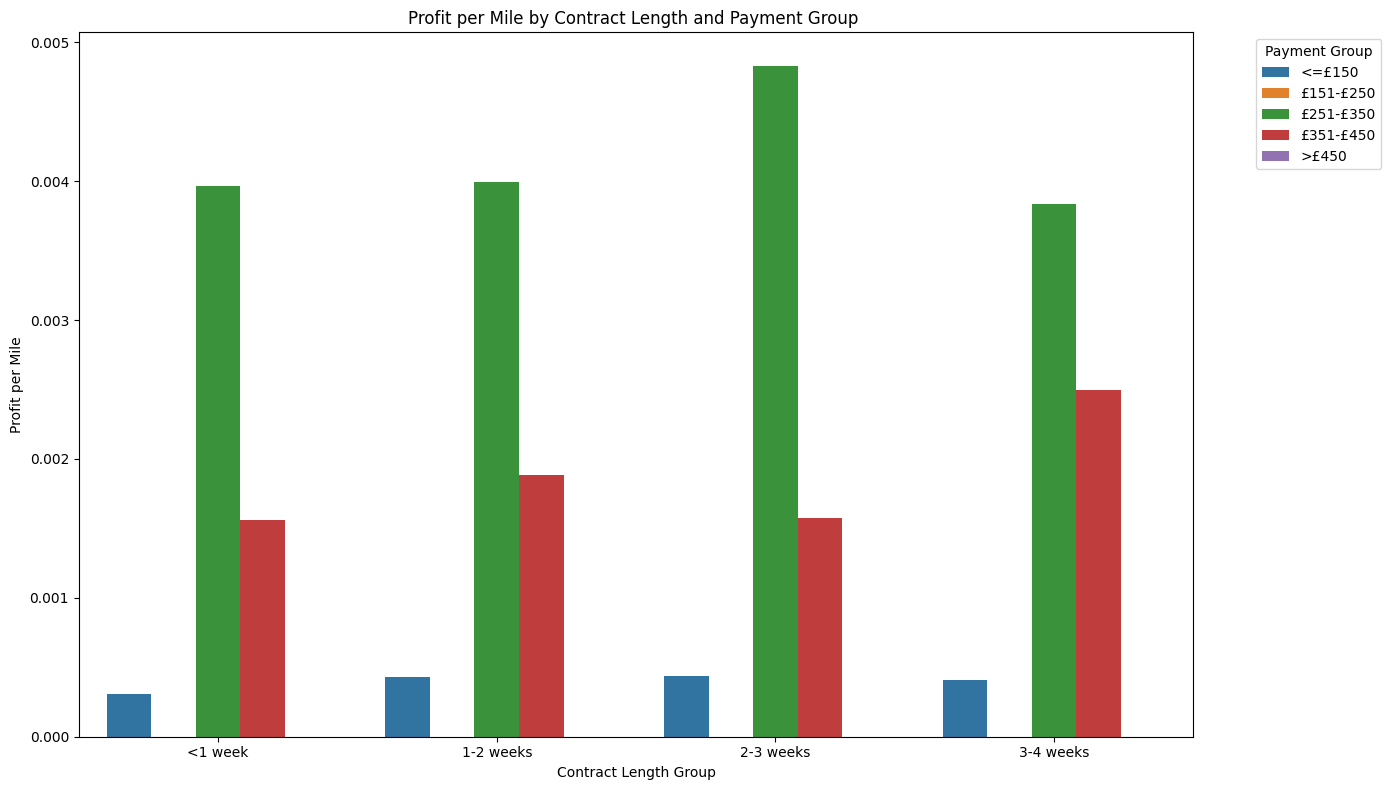

In [363]:
#
data_to_plot = filtered_group[normalized_cols].sort_values(by='profit_per_mile', ascending=False)

plt.figure(figsize=(14, 8))

# Barplot: profit_per_mile by contract_length_group, colored by payment_group
sns.barplot(
    data=data_to_plot,
    x='contract_length_group',
    y='profit_per_mile',
    hue='payment_group',
    ci=None
)

plt.title('Profit per Mile by Contract Length and Payment Group ')
plt.ylabel('Profit per Mile')
plt.xlabel('Contract Length Group')
plt.legend(title='Payment Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Short to mid-length contracts (1 to 3 weeks) offer the best balance of profitability and stable incident rates, while longer contracts generate more activity but lower profit efficiency. Incident risk is largely unaffected by contract length.